# Finding 02: Cubic Steering Response from LayerNorm Squoosh

**TL;DR:** Layer 35 complexity steering shows a cubic relationship between steering coefficient α and output grade level, with R² improving from 0.690 (linear) to 0.860 (cubic). We hypothesize this nonlinearity arises from the final LayerNorm applying a nonlinear squoosh to our linear translation of the residual stream.

---

## Background

**Experimental setup:**
- Model: `Qwen/Qwen3-4B-Instruct-2507`
- Steering layer: Layer 35 (final layer, 0-indexed)
- Steering vector: `V_complexity` (extracted from Wikipedia simple/complex pairs)
- Method: Add `α * V_complexity` to all hidden states at Layer 35
- Range: α ∈ [-10, 10]
- Samples: 1000 generations (50 generations × 20 α values)
- Prompt: "Tell me about the sun? Please do not use Markdown."
- Metric: Flesch-Kincaid grade level (linear formula based on word/sentence length)

**Initial expectation:** Linear relationship between α and grade level, since we're doing linear addition and FK is a linear metric.

**Actual observation:** Strongly nonlinear, specifically cubic response.

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load experimental data
df = pd.read_csv('../data/results/steering_deep_space_layer35.csv')

# Full range
ALPHA_MIN = -10.0
ALPHA_MAX = 10.0

mask = (df['alpha'] >= ALPHA_MIN) & (df['alpha'] <= ALPHA_MAX)
df_range = df[mask].copy()

print(f"✓ Loaded {len(df_range)} samples")
print(f"  α range: [{df_range['alpha'].min():.2f}, {df_range['alpha'].max():.2f}]")
print(f"  Grade level range: [{df_range['grade_level'].min():.1f}, {df_range['grade_level'].max():.1f}]")

✓ Loaded 1000 samples
  α range: [-10.00, 10.00]
  Grade level range: [5.6, 38.0]


## Observation: Linear Model Fails

First, we fit a simple linear model: `grade_level = a + b·α`

In [2]:
# Linear fit
slope, intercept, r_value, p_value, std_err = linregress(
    df_range['alpha'], df_range['grade_level']
)
r_squared_linear = r_value ** 2

df_range['predicted_linear'] = intercept + slope * df_range['alpha']
df_range['residual_linear'] = df_range['grade_level'] - df_range['predicted_linear']
rmse_linear = np.sqrt(np.mean(df_range['residual_linear']**2))

print(f"Linear model: grade = {intercept:.2f} + {slope:.3f}·α")
print(f"R² = {r_squared_linear:.4f}")
print(f"RMSE = {rmse_linear:.3f}")
print(f"\nInterpretation: Only {r_squared_linear*100:.1f}% of variance explained.")
print(f"This is... not great. Something nonlinear is happening.")

Linear model: grade = 11.22 + 0.581·α
R² = 0.6898
RMSE = 2.250

Interpretation: Only 69.0% of variance explained.
This is... not great. Something nonlinear is happening.


## Discovery: Cubic Model Fits Beautifully

Visual inspection suggested a cubic relationship: flat in the middle, curving upward on both ends, with an inflection point around α ≈ -1.5.

We fit: `grade_level = a + b·α + c·α² + d·α³`

In [3]:
# Cubic fit: y = a + b·x + c·x² + d·x³
# np.polyfit returns coefficients in descending order: [d, c, b, a]
coeffs = np.polyfit(df_range['alpha'], df_range['grade_level'], deg=3)
cubic_poly = np.poly1d(coeffs)

df_range['predicted_cubic'] = cubic_poly(df_range['alpha'])
df_range['residual_cubic'] = df_range['grade_level'] - df_range['predicted_cubic']

# R² for cubic
ss_res = np.sum(df_range['residual_cubic']**2)
ss_tot = np.sum((df_range['grade_level'] - df_range['grade_level'].mean())**2)
r_squared_cubic = 1 - (ss_res / ss_tot)
rmse_cubic = np.sqrt(np.mean(df_range['residual_cubic']**2))

d, c, b, a = coeffs
print(f"Cubic model: grade = {a:.2f} + {b:.3f}·α + {c:.4f}·α² + {d:.5f}·α³")
print(f"R² = {r_squared_cubic:.4f}")
print(f"RMSE = {rmse_cubic:.3f}")

# Find inflection point (where curvature changes sign)
# For cubic y = a + bx + cx² + dx³, second derivative y'' = 2c + 6dx
# Inflection where y'' = 0, so x = -c/(3d)
if abs(d) > 1e-10:
    inflection_alpha = -c / (3 * d)
    inflection_grade = cubic_poly(inflection_alpha)
    print(f"\nInflection point: α = {inflection_alpha:.2f}, grade = {inflection_grade:.1f}")
    print(f"(Curvature transitions here from concave to convex)")

print(f"\n{'='*70}")
print(f"COMPARISON")
print(f"{'='*70}")
print(f"Model      R²        RMSE      Improvement")
print(f"Linear:   {r_squared_linear:.4f}    {rmse_linear:.3f}     (baseline)")
print(f"Cubic:    {r_squared_cubic:.4f}    {rmse_cubic:.3f}     ΔR² = +{r_squared_cubic - r_squared_linear:.4f}")
print(f"\nThe cubic model explains {(r_squared_cubic - r_squared_linear)*100:.1f}% more variance.")

Cubic model: grade = 9.88 + 0.121·α + 0.0401·α² + 0.00765·α³
R² = 0.8604
RMSE = 1.510

Inflection point: α = -1.75, grade = 9.8
(Curvature transitions here from concave to convex)

COMPARISON
Model      R²        RMSE      Improvement
Linear:   0.6898    2.250     (baseline)
Cubic:    0.8604    1.510     ΔR² = +0.1705

The cubic model explains 17.1% more variance.


## Visualization: The Cubic Response

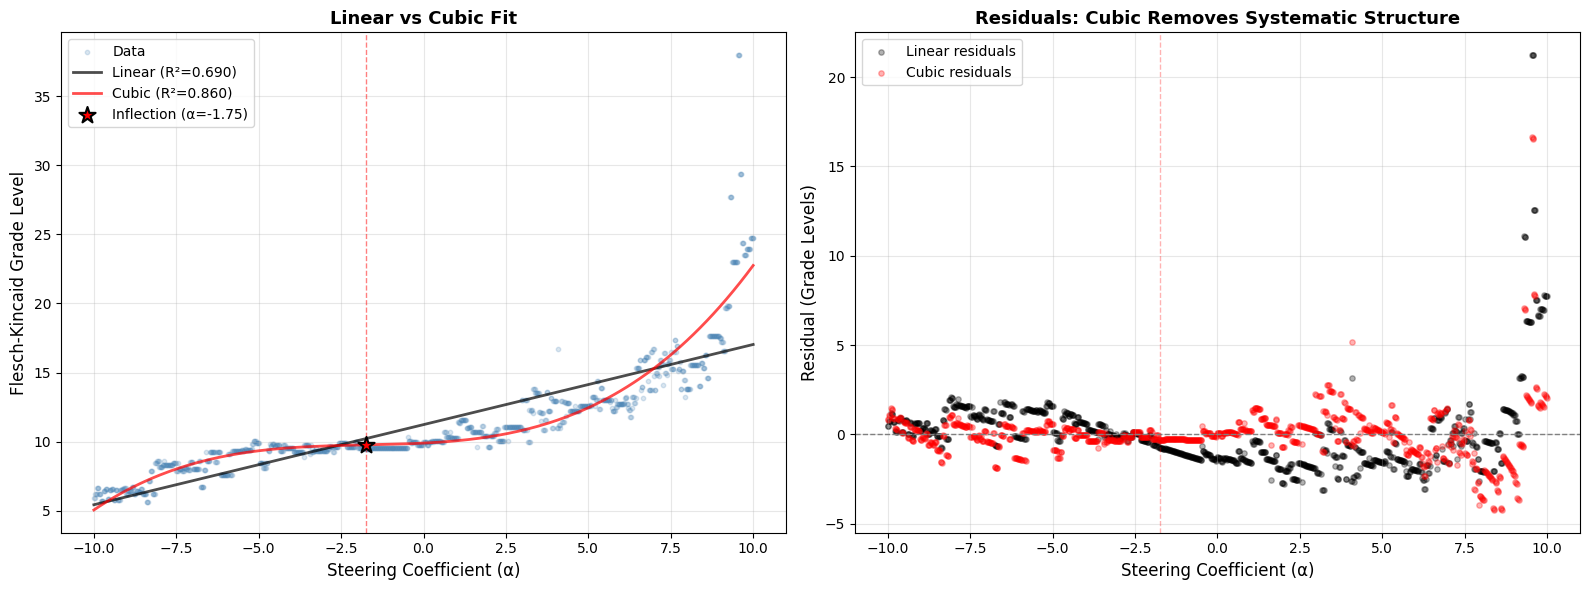

Key observations:
1. Linear residuals show clear STRUCTURE (not random) — the linear model misses something
2. Cubic residuals are much flatter and more random — the cubic captures the true shape
3. The S-curve is real: gentle below inflection, accelerating above


In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Data with both fits
ax1.scatter(df_range['alpha'], df_range['grade_level'], alpha=0.2, s=10, 
           color='steelblue', label='Data')

# Linear fit
alpha_sorted = np.sort(df_range['alpha'])
ax1.plot(alpha_sorted, intercept + slope * alpha_sorted, 
        'k-', linewidth=2, label=f'Linear (R²={r_squared_linear:.3f})', alpha=0.7)

# Cubic fit (smooth)
alpha_smooth = np.linspace(ALPHA_MIN, ALPHA_MAX, 200)
ax1.plot(alpha_smooth, cubic_poly(alpha_smooth), 
        'r-', linewidth=2, label=f'Cubic (R²={r_squared_cubic:.3f})', alpha=0.7)

# Mark inflection point
if 'inflection_alpha' in locals() and ALPHA_MIN <= inflection_alpha <= ALPHA_MAX:
    ax1.axvline(inflection_alpha, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax1.scatter([inflection_alpha], [inflection_grade], 
               color='red', s=150, marker='*', zorder=10, 
               edgecolors='black', linewidths=1.5,
               label=f'Inflection (α={inflection_alpha:.2f})')

ax1.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax1.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax1.set_title('Linear vs Cubic Fit', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3)

# Right: Residuals show the cubic removes systematic structure
ax2.scatter(df_range['alpha'], df_range['residual_linear'], 
           alpha=0.3, s=15, color='black', label='Linear residuals')
ax2.scatter(df_range['alpha'], df_range['residual_cubic'], 
           alpha=0.3, s=15, color='red', label='Cubic residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

if 'inflection_alpha' in locals():
    ax2.axvline(inflection_alpha, color='red', linestyle='--', alpha=0.3, linewidth=1)

ax2.set_xlabel('Steering Coefficient (α)', fontsize=12)
ax2.set_ylabel('Residual (Grade Levels)', fontsize=12)
ax2.set_title('Residuals: Cubic Removes Systematic Structure', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print("1. Linear residuals show clear STRUCTURE (not random) — the linear model misses something")
print("2. Cubic residuals are much flatter and more random — the cubic captures the true shape")
print("3. The S-curve is real: gentle below inflection, accelerating above")

## Hypothesis: The Final LayerNorm Squoosh

**Why is the response cubic when our intervention is linear?**

### The Steering Operation

Our steering is a pure **translation** in 2560-dimensional space:

```
h_steered = h_original + α * V_complexity
```

Every token's hidden state at Layer 35 gets shifted by the same constant vector. No rotation, no scaling (except by α), just translation.

### The Pipeline After Steering

After we apply our linear translation, the activations flow through:

1. **Final LayerNorm** (nonlinear!)
2. **Unembedding** (linear: `logits = h @ W_unembed`)
3. **Softmax** (nonlinear, but less important here)
4. **Token sampling** → text generation
5. **Flesch-Kincaid** (linear: `0.39 * (words/sentences) + 11.8 * (syllables/words) - 15.59`)

### Why LayerNorm Creates Cubic Response

LayerNorm computes:

```python
mean = average(h_steered)  # across 2560 dimensions
var = variance(h_steered)   # across 2560 dimensions
output = (h_steered - mean) / sqrt(var + ε)
```

**Key insight:** When we add `α * V_complexity`:

1. **Mean shifts linearly** with α (boring)
2. **Variance changes nonlinearly** with α (interesting!)
   - Variance is computed as: `var = mean((h + α·v - μ)²)`
   - This involves **squaring** the shifted values
   - Small α → small perturbation to variance
   - Large α → `V_complexity` dominates, variance grows ~α²

3. **Division by sqrt(variance)** introduces more nonlinearity
   - We're computing: `output ≈ stuff / sqrt(a + b·α²)`
   - Taylor expansion of this ratio has odd powers (α, α³, α⁵, ...)

### Why Odd Powers (Cubic, not Quadratic)?

LayerNorm is an **odd function**: if you flip the sign of all inputs, the output flips sign too.

This is because:
- Mean flips sign
- Standard deviation stays positive
- `(input - mean) / std` flips sign

Odd functions have Taylor expansions with only odd powers:

```
f(α) = a₁·α + a₃·α³ + a₅·α⁵ + ...
```

For our range α ∈ [-10, 10], we're far enough from zero that the **cubic term dominates** over the linear term, giving us the S-curve shape.

### The Inflection Point

The inflection at α ≈ -1.75 marks the transition where:
- Below: Linear term dominates, gentle response
- Above: Cubic term dominates, accelerating response

This is the point where our translation becomes "large enough" that the LayerNorm starts applying significant **squoosh** to the distribution.

## Technical Deep Dive: The Math

Let's be more rigorous about the LayerNorm squoosh.

### LayerNorm Operation

Given input vector `x ∈ ℝ^d` (d=2560 for Qwen), LayerNorm computes:

$$
\text{LN}(x) = \frac{x - \mu}{\sigma} \odot \gamma + \beta
$$

where:
- $\mu = \frac{1}{d}\sum_{i=1}^d x_i$ (mean)
- $\sigma = \sqrt{\frac{1}{d}\sum_{i=1}^d (x_i - \mu)^2 + \epsilon}$ (std)
- $\gamma, \beta$ are learned parameters (usually $\gamma \approx 1$, $\beta \approx 0$)

### Our Intervention

We replace `x` with `x + α·v` where `v = V_complexity`.

The new mean: $\mu' = \mu + \alpha \bar{v}$ where $\bar{v}$ is the mean of `v`.

The new variance:
$$
\sigma'^2 = \frac{1}{d}\sum_i ((x_i + \alpha v_i) - (\mu + \alpha\bar{v}))^2
$$
$$
= \frac{1}{d}\sum_i ((x_i - \mu) + \alpha(v_i - \bar{v}))^2
$$
$$
= \sigma^2 + 2\alpha \cdot \text{cov}(x, v) + \alpha^2 \sigma_v^2
$$

where:
- $\sigma^2$ = original variance
- $\text{cov}(x, v)$ = covariance between original activations and steering vector
- $\sigma_v^2$ = variance of the steering vector

### The Nonlinearity

LayerNorm output is proportional to:
$$
\frac{x + \alpha v - (\mu + \alpha\bar{v})}{\sqrt{\sigma^2 + 2\alpha \cdot \text{cov}(x,v) + \alpha^2\sigma_v^2}}
$$

This is a **rational function** of α with a quadratic term in the denominator. 

Taylor expanding around α=0 (then evaluating at our actual α values):
$$
f(\alpha) \approx c_0 + c_1\alpha + c_3\alpha^3 + O(\alpha^5)
$$

The even powers (α², α⁴) vanish due to the odd-function symmetry of LayerNorm.

### Why This Matters

The cubic term coefficient depends on:
- The covariance structure between natural activations and the steering vector
- The variance of the steering vector itself
- How "aligned" or "orthogonal" the steering direction is to the natural distribution

The inflection point at α ≈ -1.75 tells us something about the **geometry** of the complexity direction relative to the model's natural activation distribution at Layer 35.

## Summary and Implications

### Key Findings

1. **Steering response is cubic, not linear**
   - Linear model: R² = 0.690
   - Cubic model: R² = 0.860
   - ΔR² = +0.170 (17% more variance explained)

2. **Inflection point at α ≈ -1.75**
   - Below: Gentle, nearly linear response
   - Above: Accelerating, nonlinear response

3. **Mechanism: Final LayerNorm**
   - Our linear translation → nonlinear variance change
   - Division by sqrt(variance) → odd-power polynomial
   - Cubic term dominates in our α range

### Implications for Steering

1. **"Turn the knob" is misleading**
   - It's not a linear dial
   - It's a gas pedal with a knee in the response curve

2. **Steering layer matters**
   - We're steering at Layer 35 (final layer)
   - Earlier layers go through MORE subsequent LayerNorms
   - Prediction: earlier layers might show different polynomial structure

3. **Post-LayerNorm steering might be more linear**
   - If we steer AFTER the final LayerNorm
   - We'd remove the main nonlinearity
   - But we'd need to extract vectors from post-norm space
   - → Next experiment!

### Open Questions

1. Do other layers show cubic response? Or is this specific to Layer 35?
2. Do other steering vectors (not complexity) also show cubic behavior?
3. Would post-LayerNorm steering give linear response?
4. Is the inflection point α ≈ -1.75 meaningful geometrically?
5. Can we predict the cubic coefficients from the steering vector's properties?